# Applying OT-intNMF to PBMC

## Imports

In [44]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [45]:
# Plotting
import matplotlib.pyplot as plt

In [46]:
# Our packages
from scmiot import models, pl, tl

In [47]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [48]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

In [49]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

In [50]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

In [51]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=1000)
np.sum(rna.var.highly_variable)

1000

In [52]:
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7, n_top_genes=1000)
np.sum(atac.var.highly_variable)

1000

## Subsample

In [53]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

In [54]:
sc.pp.subsample(rna, n_obs=800, random_state=0)
sc.pp.subsample(atac, n_obs=800, random_state=0)

In [55]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [56]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 800 × 128106
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	800 x 22020
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	800 x 106086
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'hvg'

## OT-intNMF

### Train model

In [57]:
# hyperparameters
eps = .1
latent_dim = 20
rho_h = 5e-2
rho_w = 5e-2

In [58]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='cosine')

In [59]:
nmf.fit_transform(mdata, max_iter_inner=2_000, max_iter=100, device='cpu', dtype=torch.double, lr=5e-1, tol_inner=1e-8, tol_outer=1e-2, optim_name='lbfgs')

 19%|█▉        | 38/200 [1:13:44<5:11:17, 115.29s/it, loss=-219.47410667805215, loss_inner=-7.130038409815427]

### Convergence plots

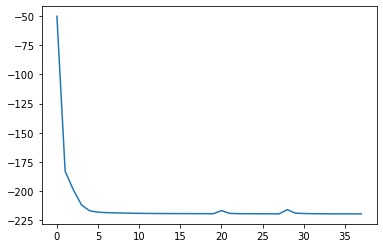

In [60]:
plt.plot(nmf.losses)

### Viz

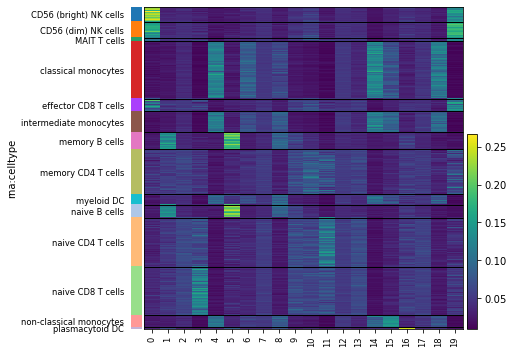

In [61]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

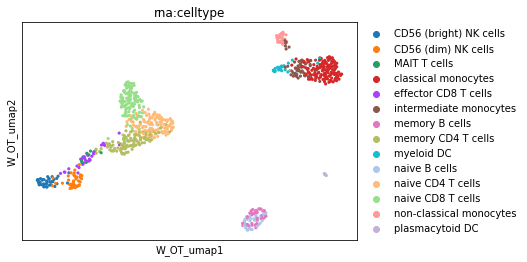

In [62]:
tl.umap(mdata, 'W_OT')
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Clustering

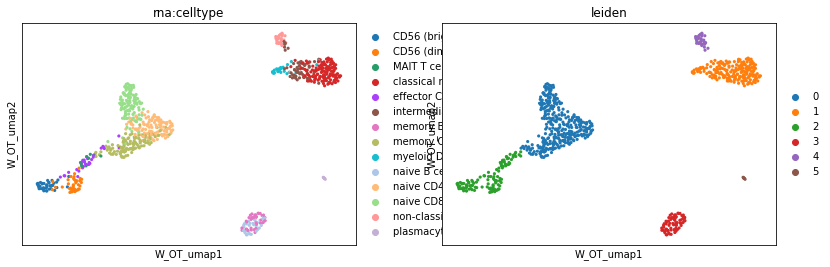

In [63]:
tl.leiden(mdata, resolution=.1)
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=40)

## Enrichment

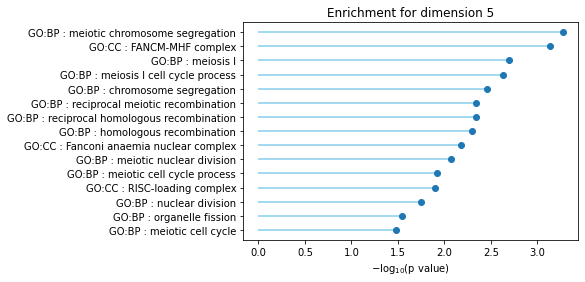

In [92]:
# Work in progress
tl.enrich(mdata, mod='rna', uns='H_OT', dim=5, ignore_first=500, n_genes=700, sources=['GO:MF', 'GO:CC', 'GO:BP'], ordered=True, display_max=15);